# QAQC Plot for LARGEEE

Note: Change `table_name` in "Load Data" Section before running notebook (they are marked with TODO)

## Import modules

In [1]:
import pandas as pd
from pathlib import Path

# from buildstock_query import BuildStockQuery
import qaqc_helper

## Constants & Funcs

In [15]:
output_dir = Path(".").resolve() / "data" / "output"
output_dir.mkdir(parents=True, exist_ok=True)


## Download data

In [3]:
### run CLI to see what's available
!aws s3 ls eussrr2/test_runs/

'aws' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
table_name = "small_run_20240126" ## <---- TODO: specify table for download
s3_prefix = f"test_runs/{table_name}/" 

data_dir = qaqc_helper.s3_download.get_localdir_for_run(s3_prefix)
qaqc_helper.s3_download.download_s3_files(s3_prefix, destination=data_dir)

Data directory: C:\Users\pwhite2\Documents\GitHub\eussrr2\resstock\docs\validation\data\small_run_20240126
S3 directory: s3://eussrr2/test_runs/small_run_20240126/baseline/ downloaded to: C:\Users\pwhite2\Documents\GitHub\eussrr2\resstock\docs\validation\data\small_run_20240126
S3 directory: s3://eussrr2/test_runs/small_run_20240126/upgrades/ downloaded to: C:\Users\pwhite2\Documents\GitHub\eussrr2\resstock\docs\validation\data\small_run_20240126


### Load

In [2]:
N_UNITS = 136569411
table_name = "small_run_20240126" # <--- folder containing upgrades only 
data_dir = qaqc_helper.s3_download.get_localdir_for_run(table_name)
baseline_data_dir = Path(".").resolve() / "data" / "small_run_20240126_baseline" # <--- TODO: make sure baseline is correct
print(f"baseline_data_dir: {baseline_data_dir}")

Data directory: C:\Users\pwhite2\Documents\GitHub\eussrr2\resstock\docs\validation\data\small_run_20240126
baseline_data_dir: C:\Users\pwhite2\Documents\GitHub\eussrr2\resstock\docs\validation\data\small_run_20240126_baseline


### Flag failure and invalid samples
Invalid means upgrades does not apply

In [3]:
dfb, DFU = qaqc_helper.load_process.load_baseline_and_upgrades(data_dir, baseline_data_dir=baseline_data_dir, success_only=True)


        Returned output is: 
            first output: baseline dataframe
            second output: dictionary of upgrade packages, with key = upgrade_name and value = upgrade dataframe
        
Baseline: completed_status
Success    500
Name: building_id, dtype: int64
Upgrade ENERGY STAR heat pump with elec backup: completed_status
Invalid     11
Success    489
Name: building_id, dtype: int64
Upgrade High efficiency cold-climate heat pump with elec backup: completed_status
Invalid     11
Success    489
Name: building_id, dtype: int64
Upgrade Ultra high efficiency heat pump with elec backup: completed_status
Invalid     11
Success    489
Name: building_id, dtype: int64
Upgrade ENERGY STAR heat pump with existing system as backup: completed_status
Fail         5
Invalid    147
Success    348
Name: building_id, dtype: int64
Upgrade Geothermal heat pump: completed_status
Fail         2
Invalid     69
Success    429
Name: building_id, dtype: int64
Upgrade ENERGY STAR heat pump with elec b

In [4]:
### check what's available based on key word
key_word = "report_simulation_output.fuel_use" # <---
[col for col in dfb.columns if key_word in col]

['report_simulation_output.fuel_use_coal_total_m_btu',
 'report_simulation_output.fuel_use_electricity_net_m_btu',
 'report_simulation_output.fuel_use_electricity_total_m_btu',
 'report_simulation_output.fuel_use_fuel_oil_total_m_btu',
 'report_simulation_output.fuel_use_natural_gas_total_m_btu',
 'report_simulation_output.fuel_use_propane_total_m_btu',
 'report_simulation_output.fuel_use_wood_cord_total_m_btu',
 'report_simulation_output.fuel_use_wood_pellets_total_m_btu']

### Check fixed costs are being removed when a fuel is no longer being used

In [8]:
enduse_list = ['coal', 'electricity','fuel_oil','natural_gas','propane','wood_cord','wood_pellets']
for enduse in enduse_list:
    Error = 0
    for row in range(1,len(dfb)):
        if dfb.iloc[row][f'report_simulation_output.fuel_use_{enduse}_total_m_btu'] == 0 and dfb.iloc[row][f'report_utility_bills.utility_rates_fixed_variable_{enduse}_fixed_usd'] !=0:
            Error += 1
    if Error > 0:
        print("Error: " + enduse)
    if Error == 0:
        print("Fixed costs are being removed when a fuel is no longer being used: "+enduse)

Fixed costs are being removed when a fuel is no longer being used: electricity


KeyError: 'report_utility_bills.utility_rates_fixed_variable_fuel_oil_fixed_usd'

### Results

#### 1. Energy savings

check fuel type with consumption

In [9]:
fuel_list = ['coal', 'electricity','fuel_oil','natural_gas','propane','wood_cord','wood_pellets']
fuel_end_use_with_changes = []
for fuel in fuel_list:
    if dfb[f'report_simulation_output.fuel_use_{fuel}_total_m_btu'].any() == True:
        print(f'report_simulation_output.fuel_use_{fuel}_total_m_btu')

report_simulation_output.fuel_use_electricity_total_m_btu
report_simulation_output.fuel_use_fuel_oil_total_m_btu
report_simulation_output.fuel_use_natural_gas_total_m_btu
report_simulation_output.fuel_use_propane_total_m_btu
report_simulation_output.fuel_use_wood_cord_total_m_btu


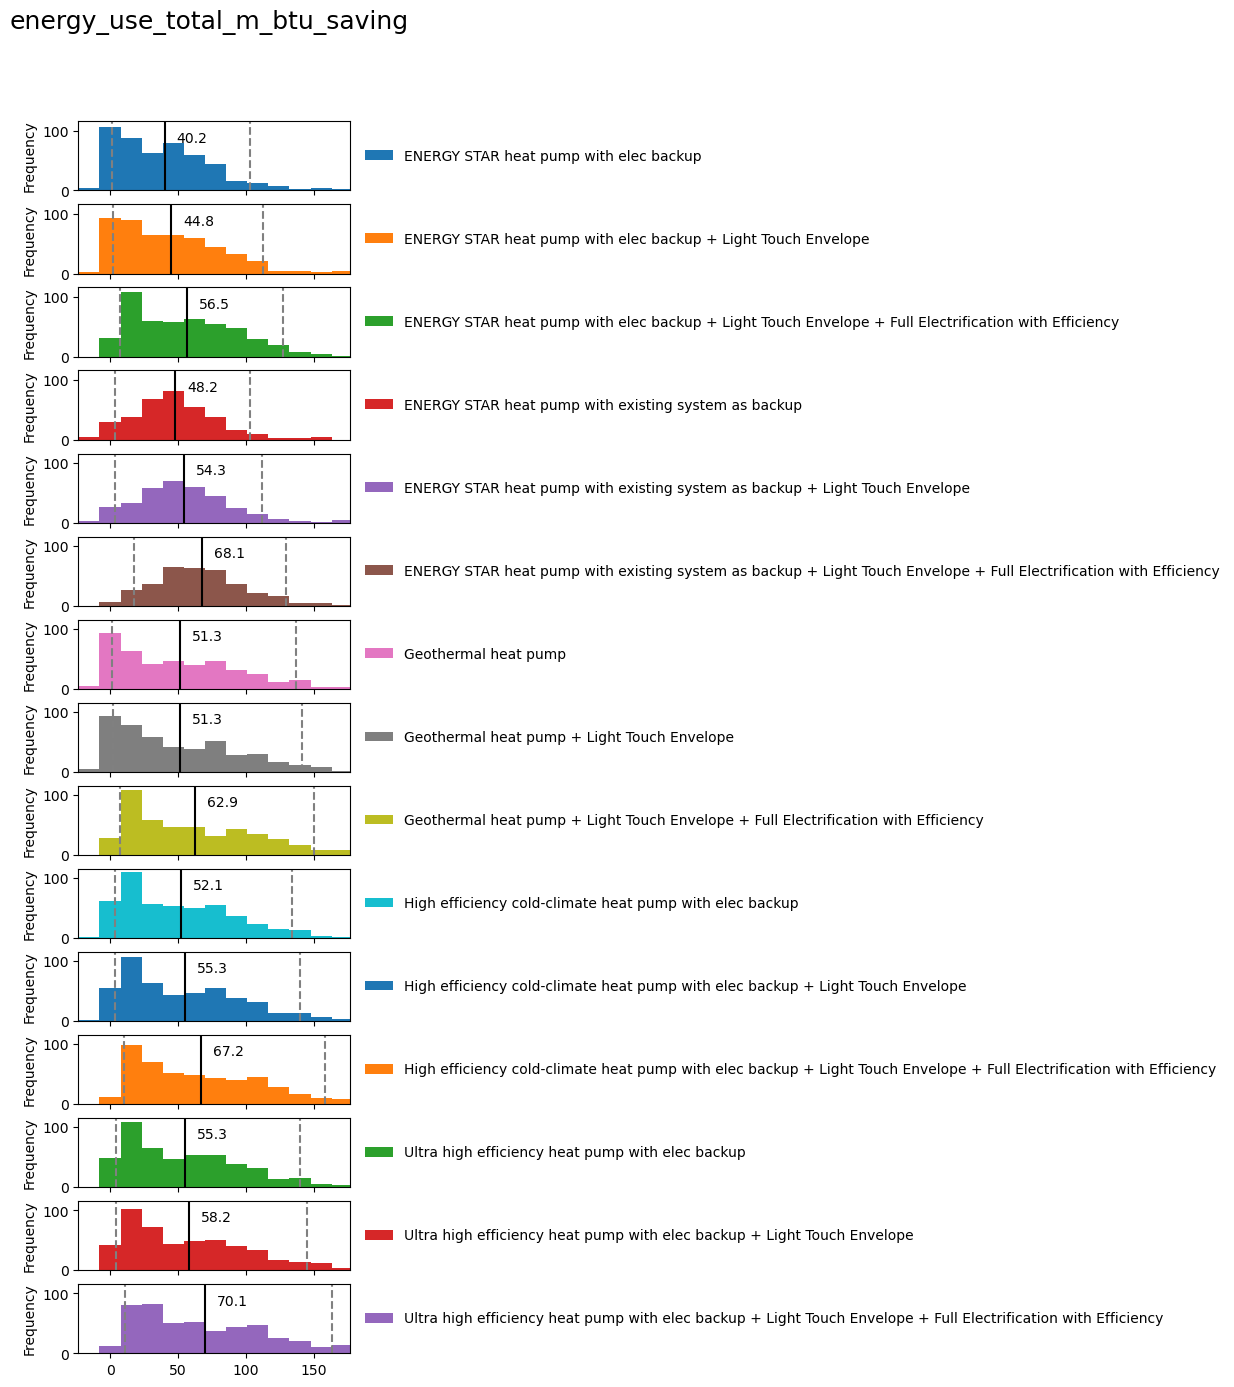

In [10]:
metric = "report_simulation_output.energy_use_total_m_btu"
output_type = "saving" # negative saving means net increase

hc = ["upgrade"]
nbins = 20

dfs = qaqc_helper.load_process.get_upgrade_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

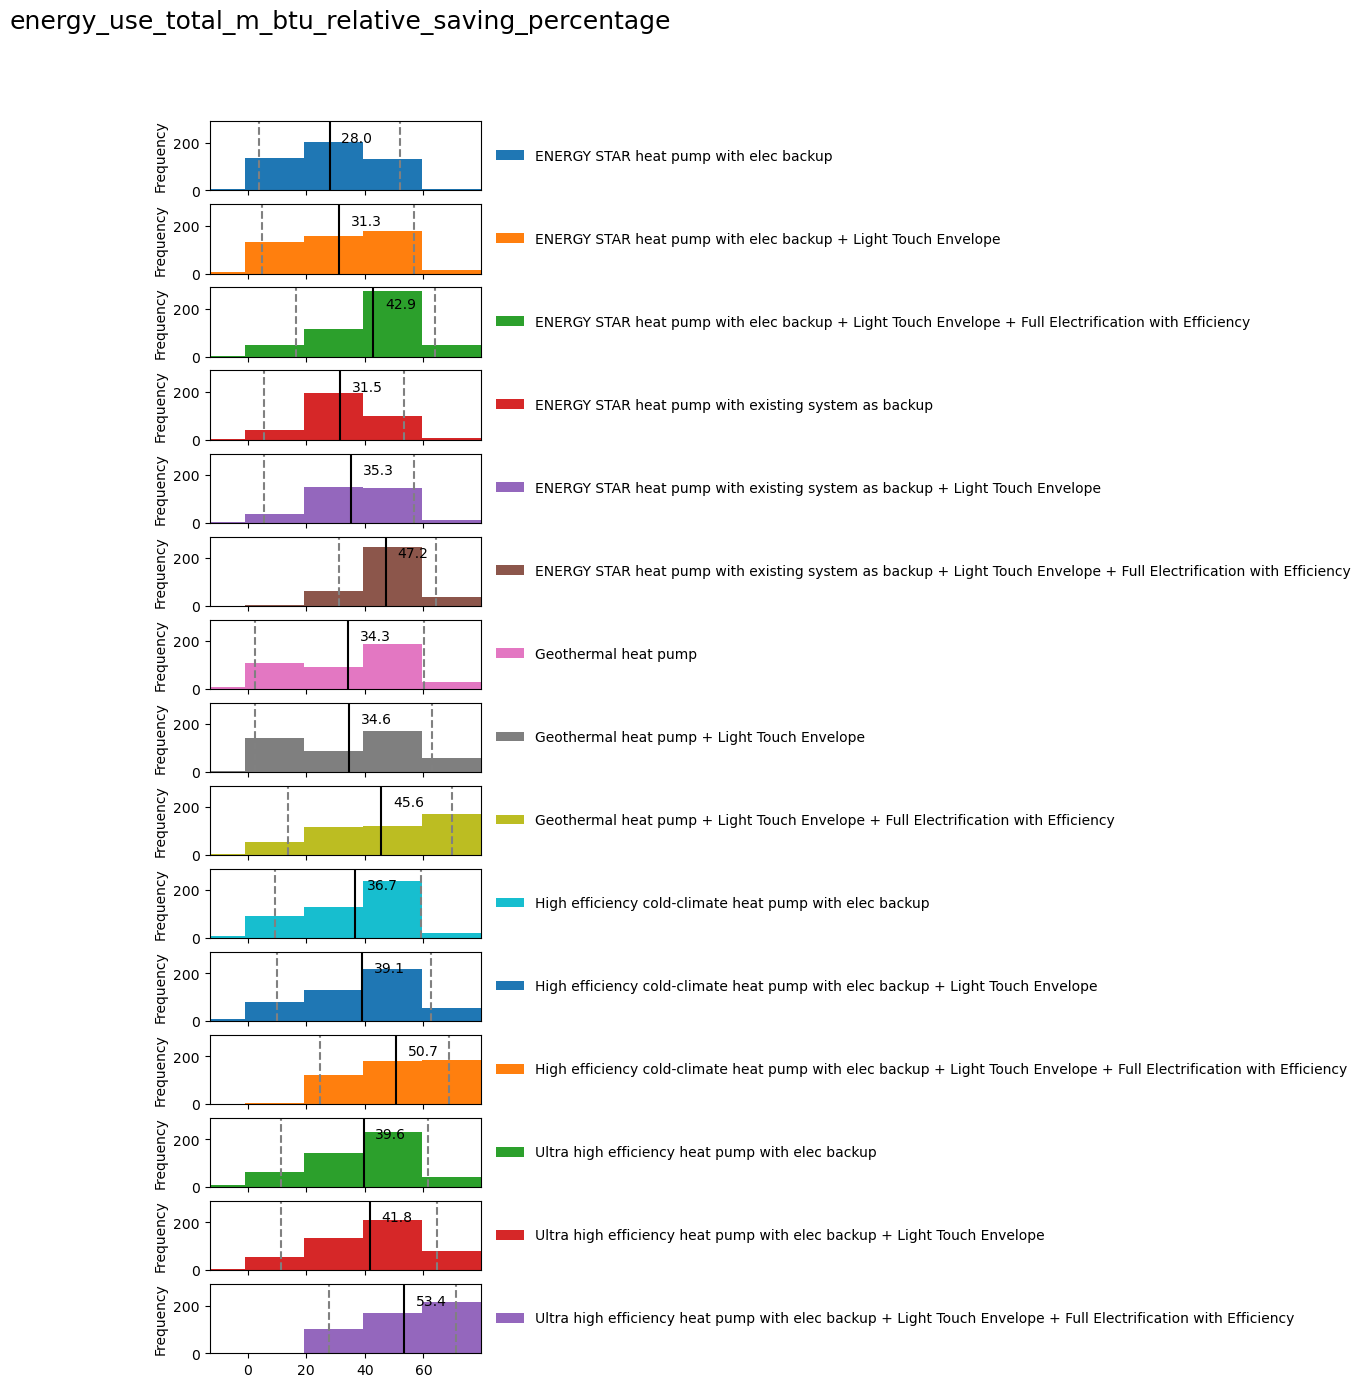

In [12]:
metric = "report_simulation_output.energy_use_total_m_btu"
output_type = "relative_saving_percentage" # negative saving means net increase

hc = ["upgrade"]
nbins = 10

dfs = qaqc_helper.load_process.get_upgrade_relative_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

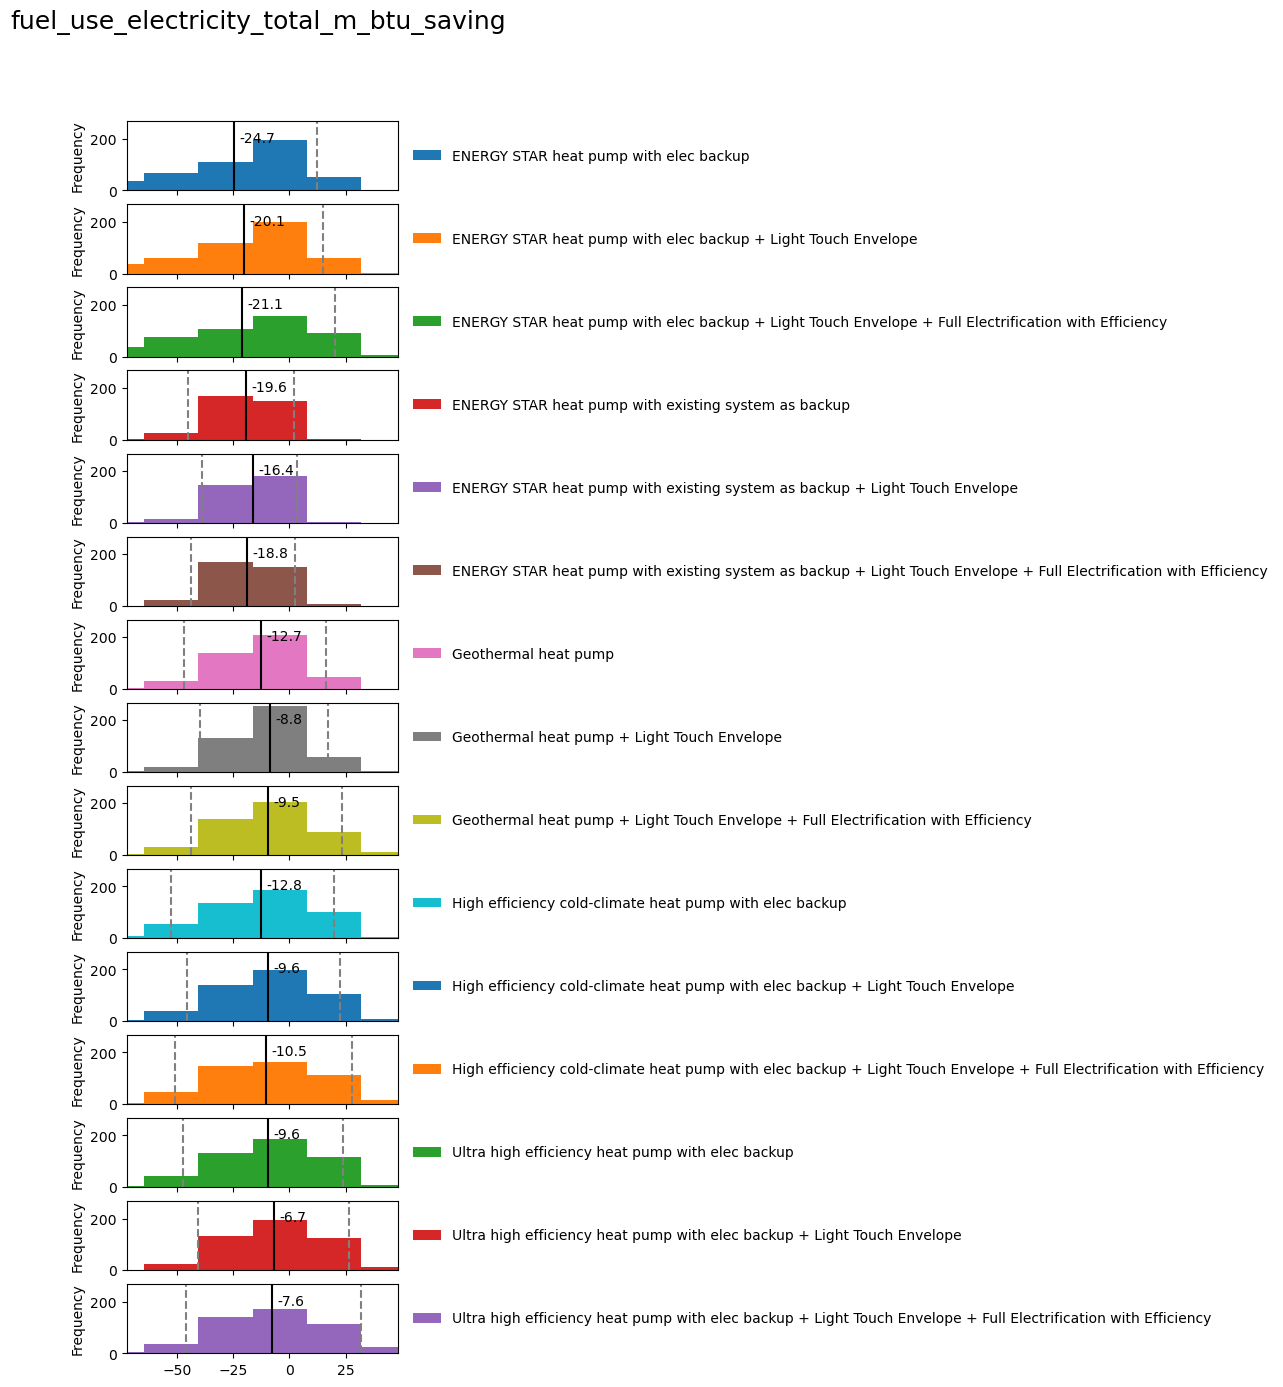

In [13]:
metric = "report_simulation_output.fuel_use_electricity_total_m_btu"
output_type = "saving" # negative saving means net increase

hc = ["upgrade"]
nbins = 10

dfs = qaqc_helper.load_process.get_upgrade_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

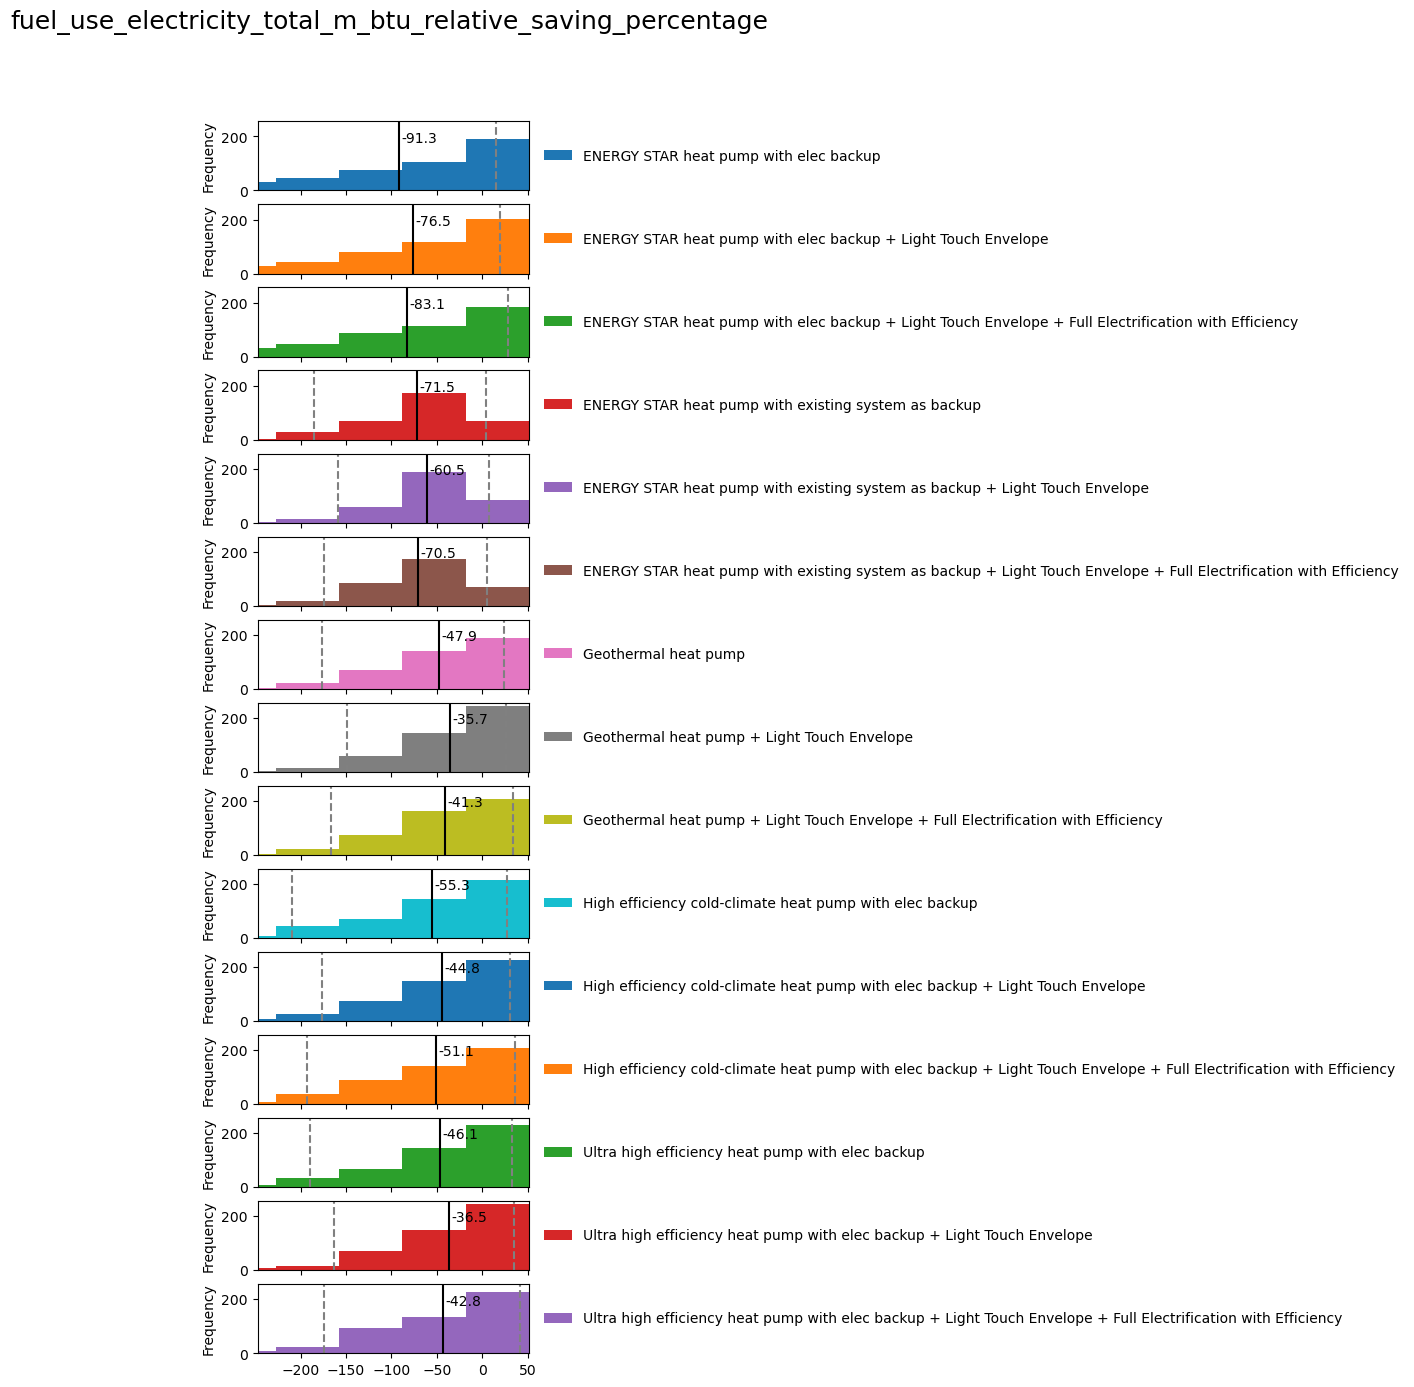

In [14]:
#check the data processing for electricity relatice saving
metric = "report_simulation_output.fuel_use_electricity_total_m_btu"
output_type = "relative_saving_percentage" # negative saving means net increase

hc = ["upgrade"]
nbins = 10

dfs = qaqc_helper.load_process.get_upgrade_relative_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

In [15]:
metric = "report_simulation_output.fuel_use_fuel_oil_total_m_btu"
output_type = "saving" # negative saving means net increase

hc = ["upgrade"]
nbins = 10

dfs = qaqc_helper.load_process.get_upgrade_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

ValueError: Image size of 68039x1387 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 350x1600 with 15 Axes>

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

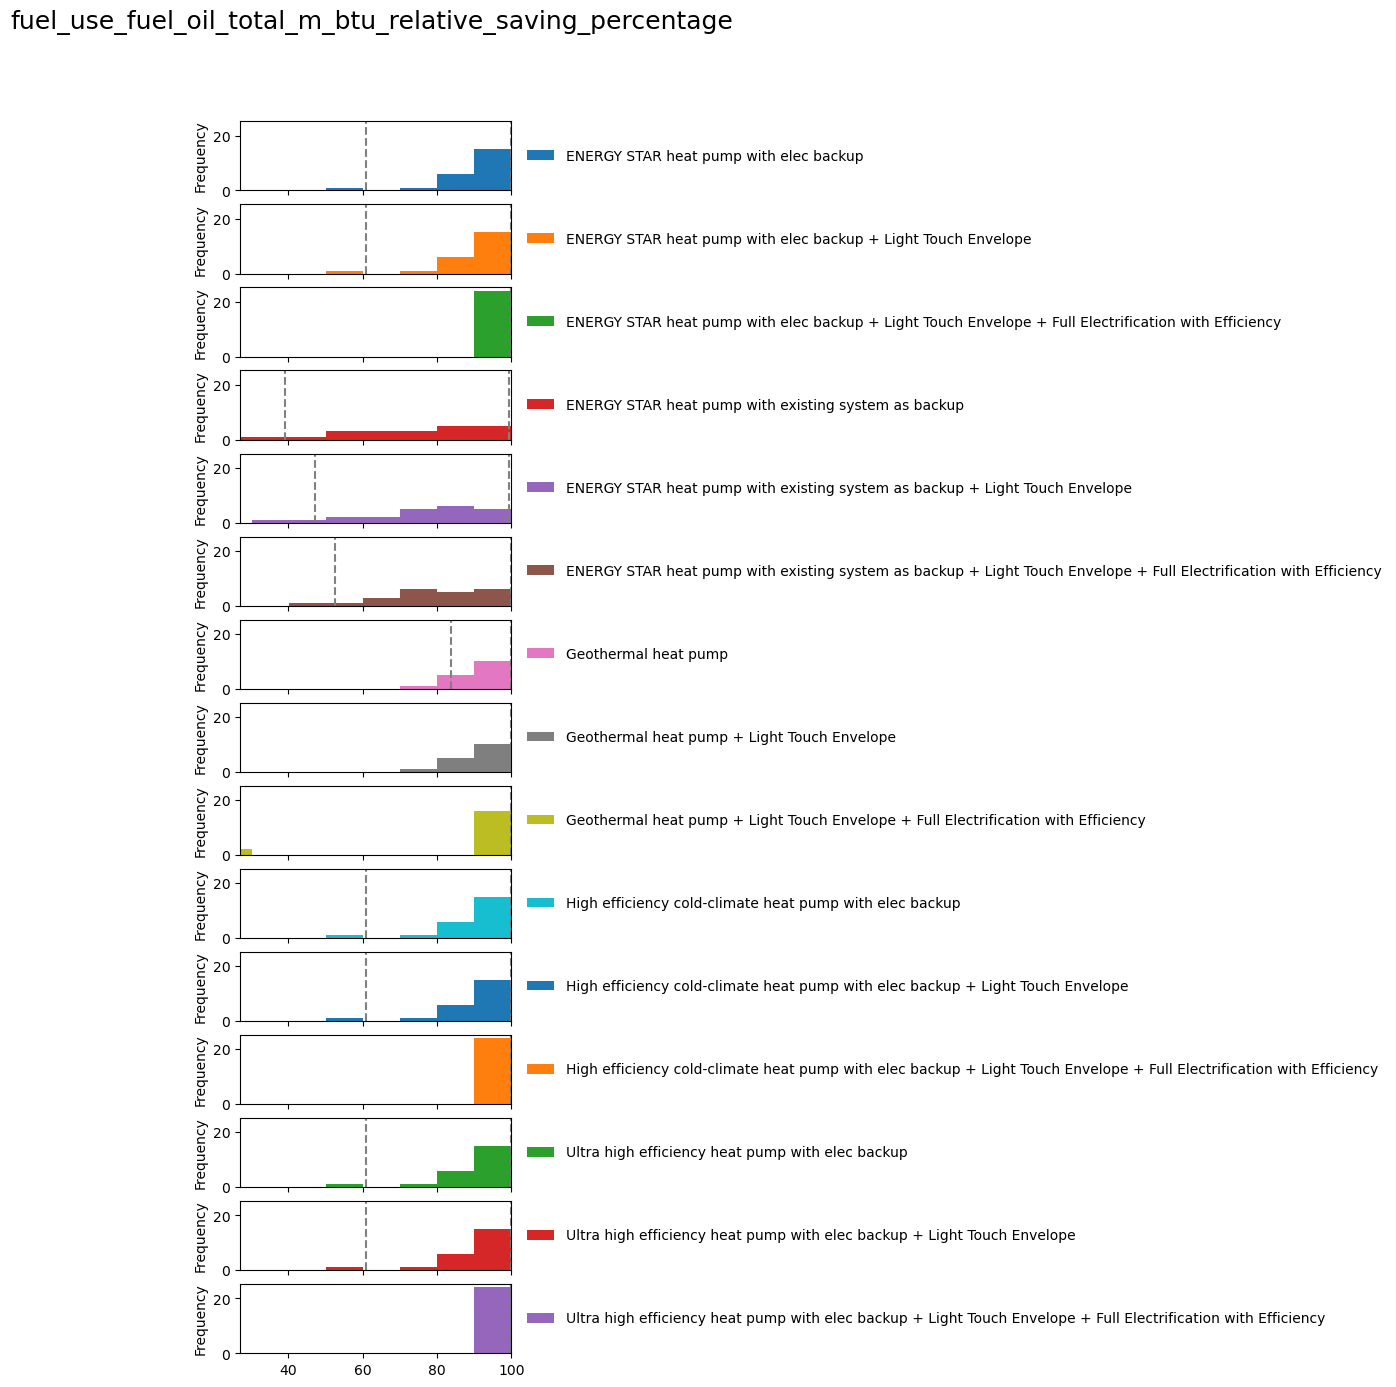

In [16]:
metric = "report_simulation_output.fuel_use_fuel_oil_total_m_btu"
output_type = "relative_saving_percentage" # negative saving means net increase

hc = ["upgrade"]
nbins = 10

dfs = qaqc_helper.load_process.get_upgrade_relative_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

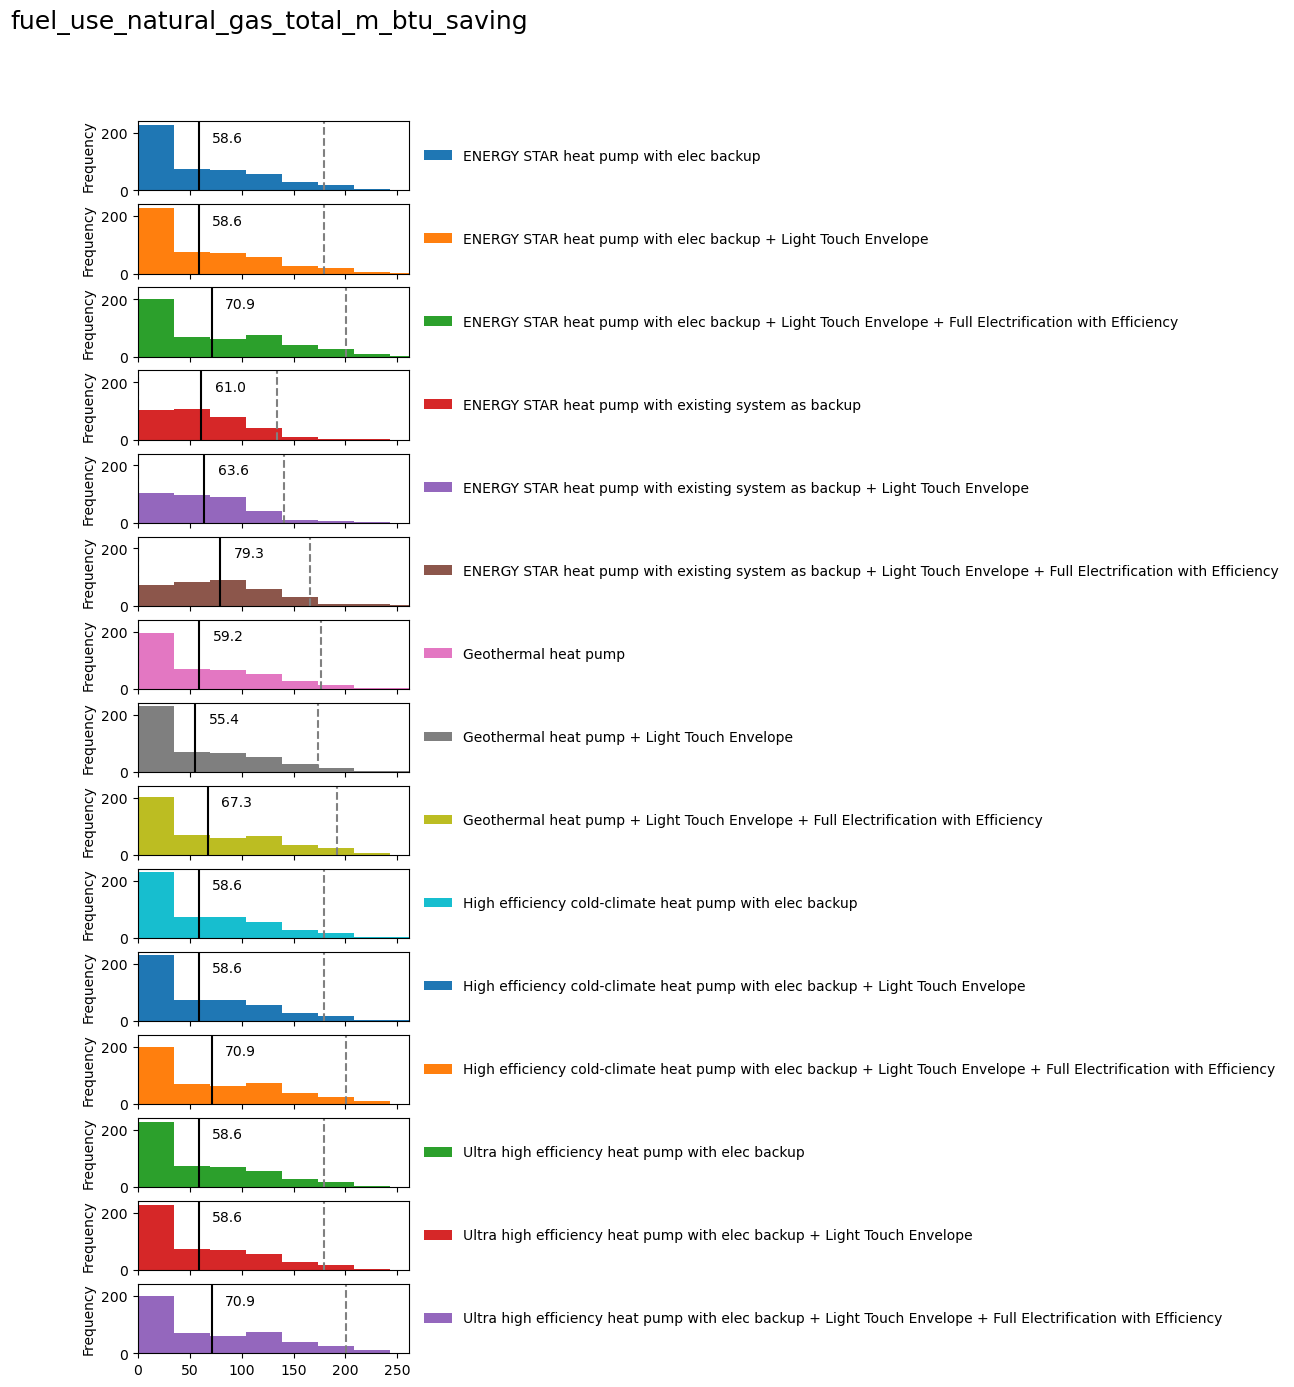

In [17]:
metric = "report_simulation_output.fuel_use_natural_gas_total_m_btu"
output_type = "saving" # negative saving means net increase

hc = ["upgrade"]
nbins = 10

dfs = qaqc_helper.load_process.get_upgrade_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

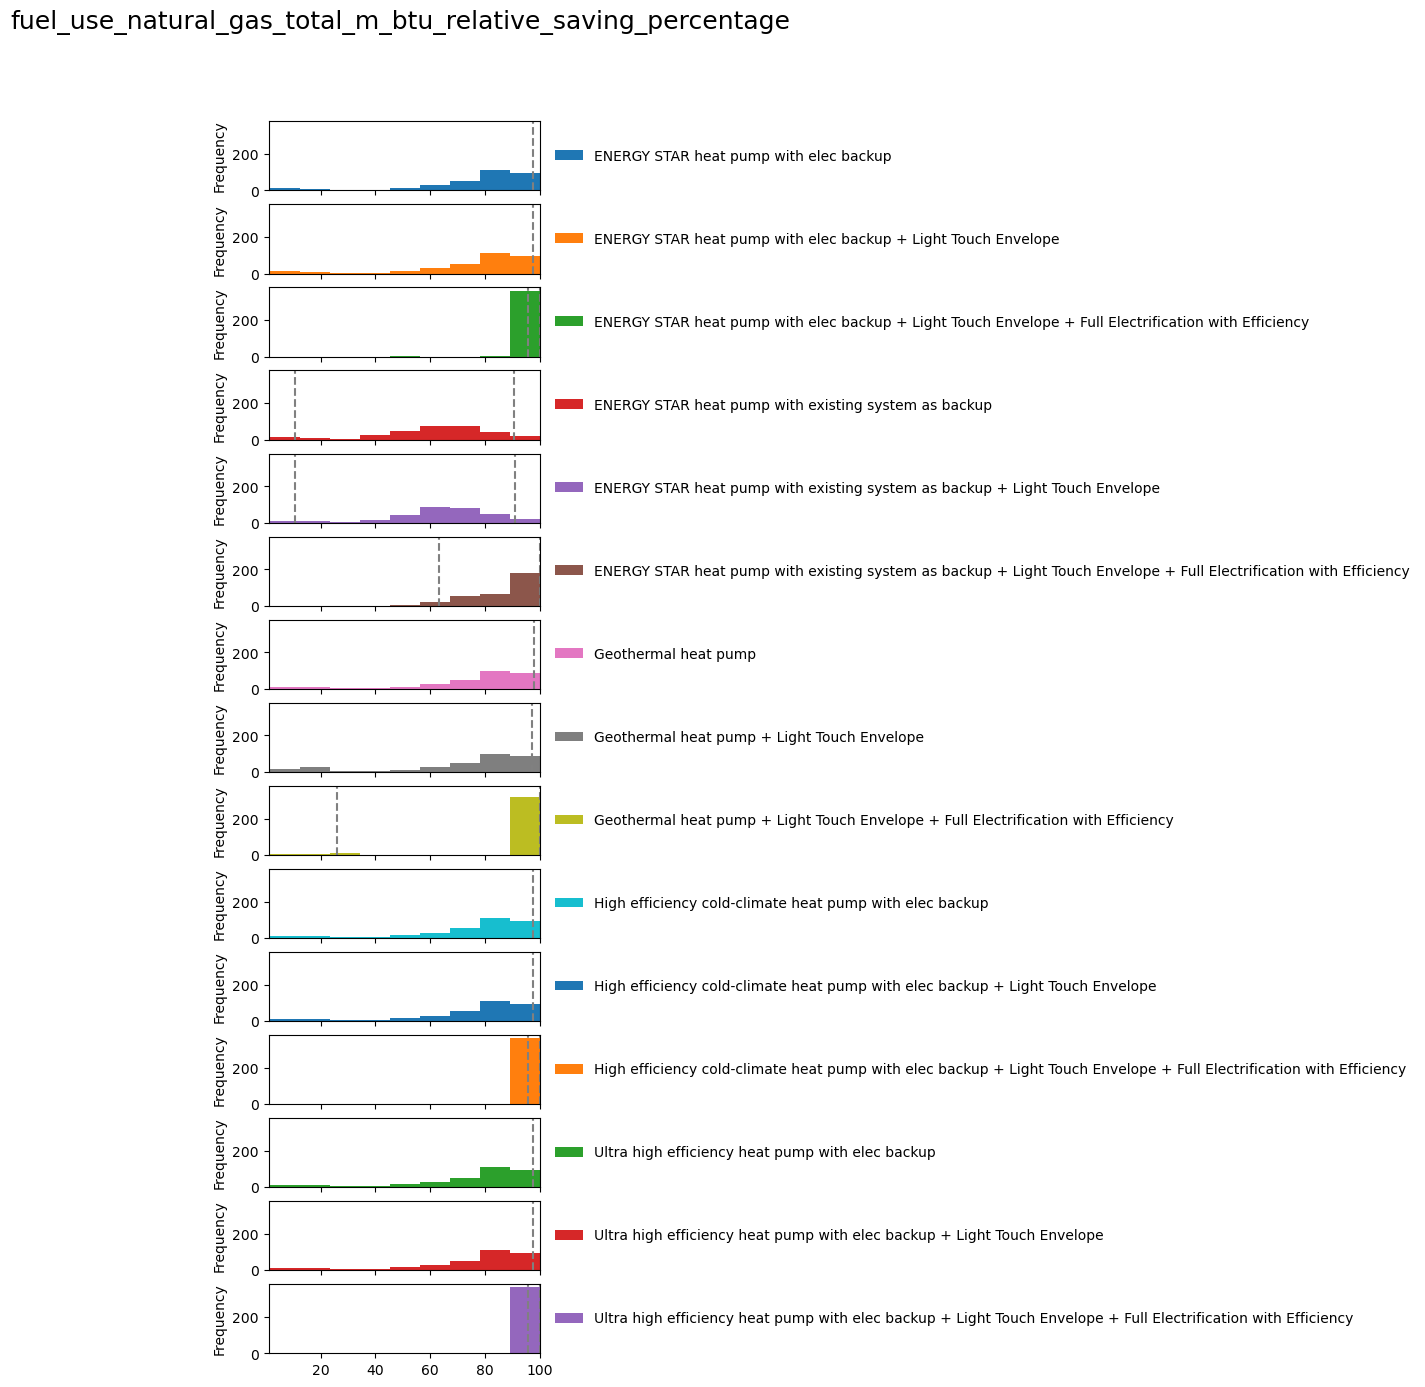

In [18]:
metric = "report_simulation_output.fuel_use_natural_gas_total_m_btu"
output_type = "relative_saving_percentage" # negative saving means net increase

hc = ["upgrade"]
nbins = 10

dfs = qaqc_helper.load_process.get_upgrade_relative_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

#### 2. Upgrade costs

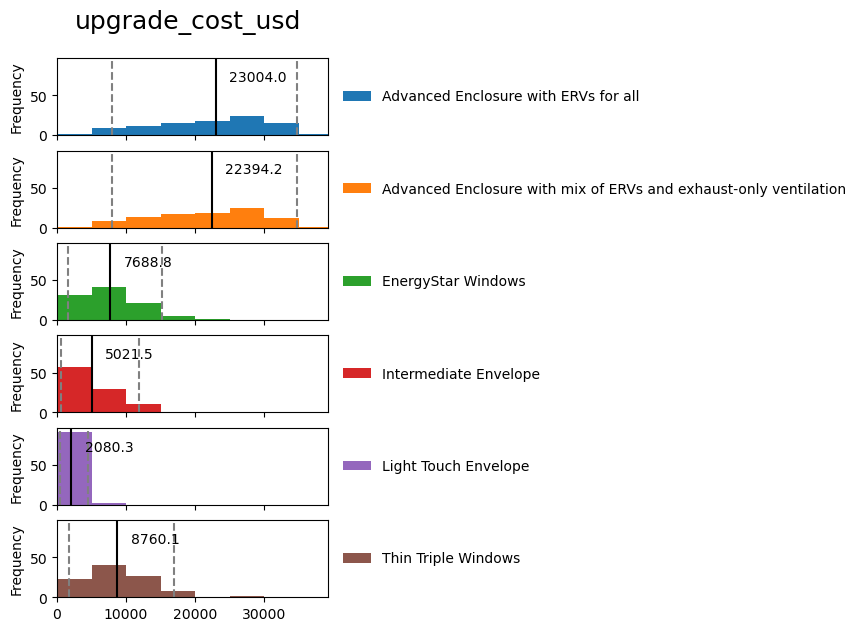

In [19]:
metric = "upgrade_costs.upgrade_cost_usd"
output_type = None
hc = ["upgrade"]
nbins = 10

dfs = qaqc_helper.load_process.get_upgrade_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric, hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

#### 3. Bill savings

In [19]:
metric = "report_utility_bills.utility_rates_fixed_variable_total_usd"
output_type = "saving" # negative saving means net increase

hc = ["upgrade"]
nbins = 10
#dark line is average value
dfs = qaqc_helper.load_process.get_upgrade_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

KeyError: 'report_utility_bills.utility_rates_fixed_variable_total_usd'

In [20]:
metric = "report_utility_bills.utility_rates_fixed_variable_total_usd"
output_type = "relative_saving_percentage" # negative saving means net increase

hc = ["upgrade"] # "lmi", "tenure"
nbins = 10

dfs = qaqc_helper.load_process.get_upgrade_relative_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

KeyError: 'report_utility_bills.utility_rates_fixed_variable_total_usd'

#### 4. Emission savings

In [21]:
metric = "report_simulation_output.emissions_co_2_e_lrmer_high_re_cost_2030_boxavg_total_lb"
output_type = "saving" # negative saving means net increase

hc = ["upgrade"] # "lmi", "tenure"
nbins = 10

dfs = qaqc_helper.load_process.get_upgrade_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

KeyError: 'report_simulation_output.emissions_co_2_e_lrmer_high_re_cost_2030_boxavg_total_lb'

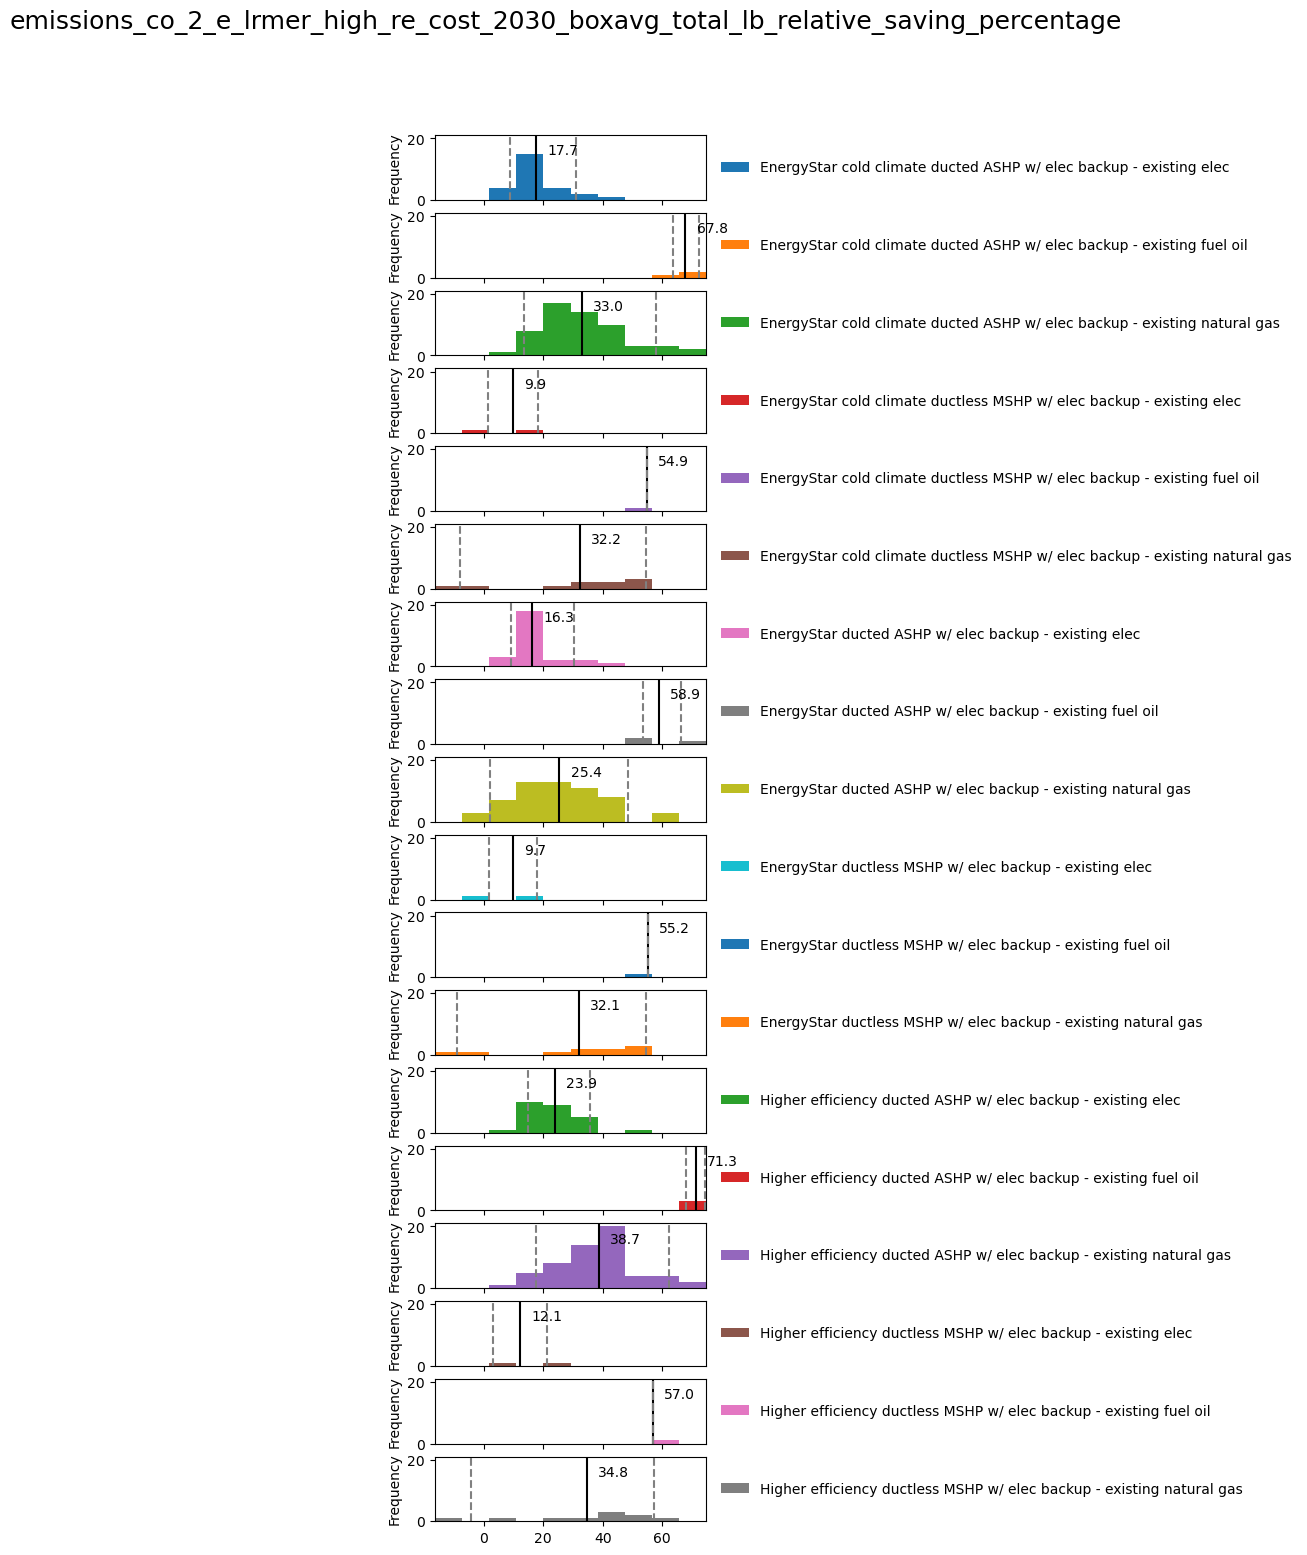

In [97]:
metric = "report_simulation_output.emissions_co_2_e_lrmer_high_re_cost_2030_boxavg_total_lb"
output_type = "relative_saving_percentage" # negative saving means net increase

hc = ["upgrade"] # "lmi", "tenure"
nbins = 10

dfs = qaqc_helper.load_process.get_upgrade_relative_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

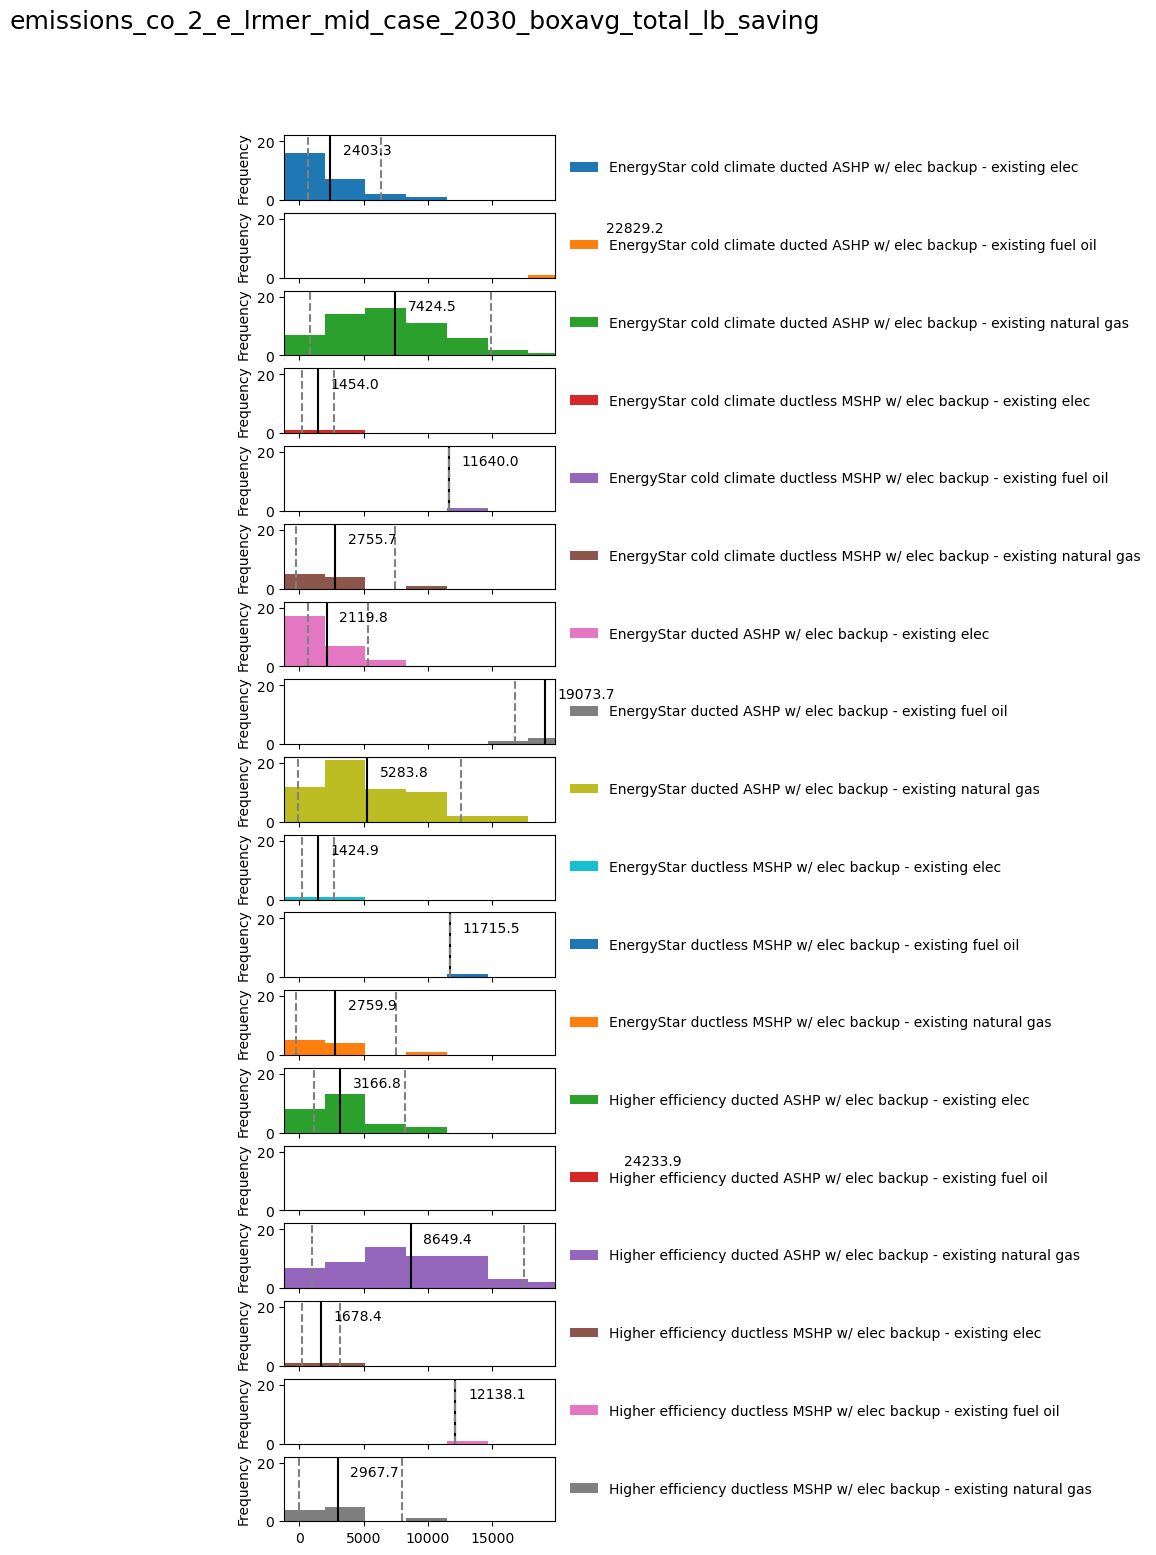

In [98]:
metric = "report_simulation_output.emissions_co_2_e_lrmer_mid_case_2030_boxavg_total_lb"
output_type = "saving" # negative saving means net increase

hc = ["upgrade"] # "lmi", "tenure"
nbins = 10

dfs = qaqc_helper.load_process.get_upgrade_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

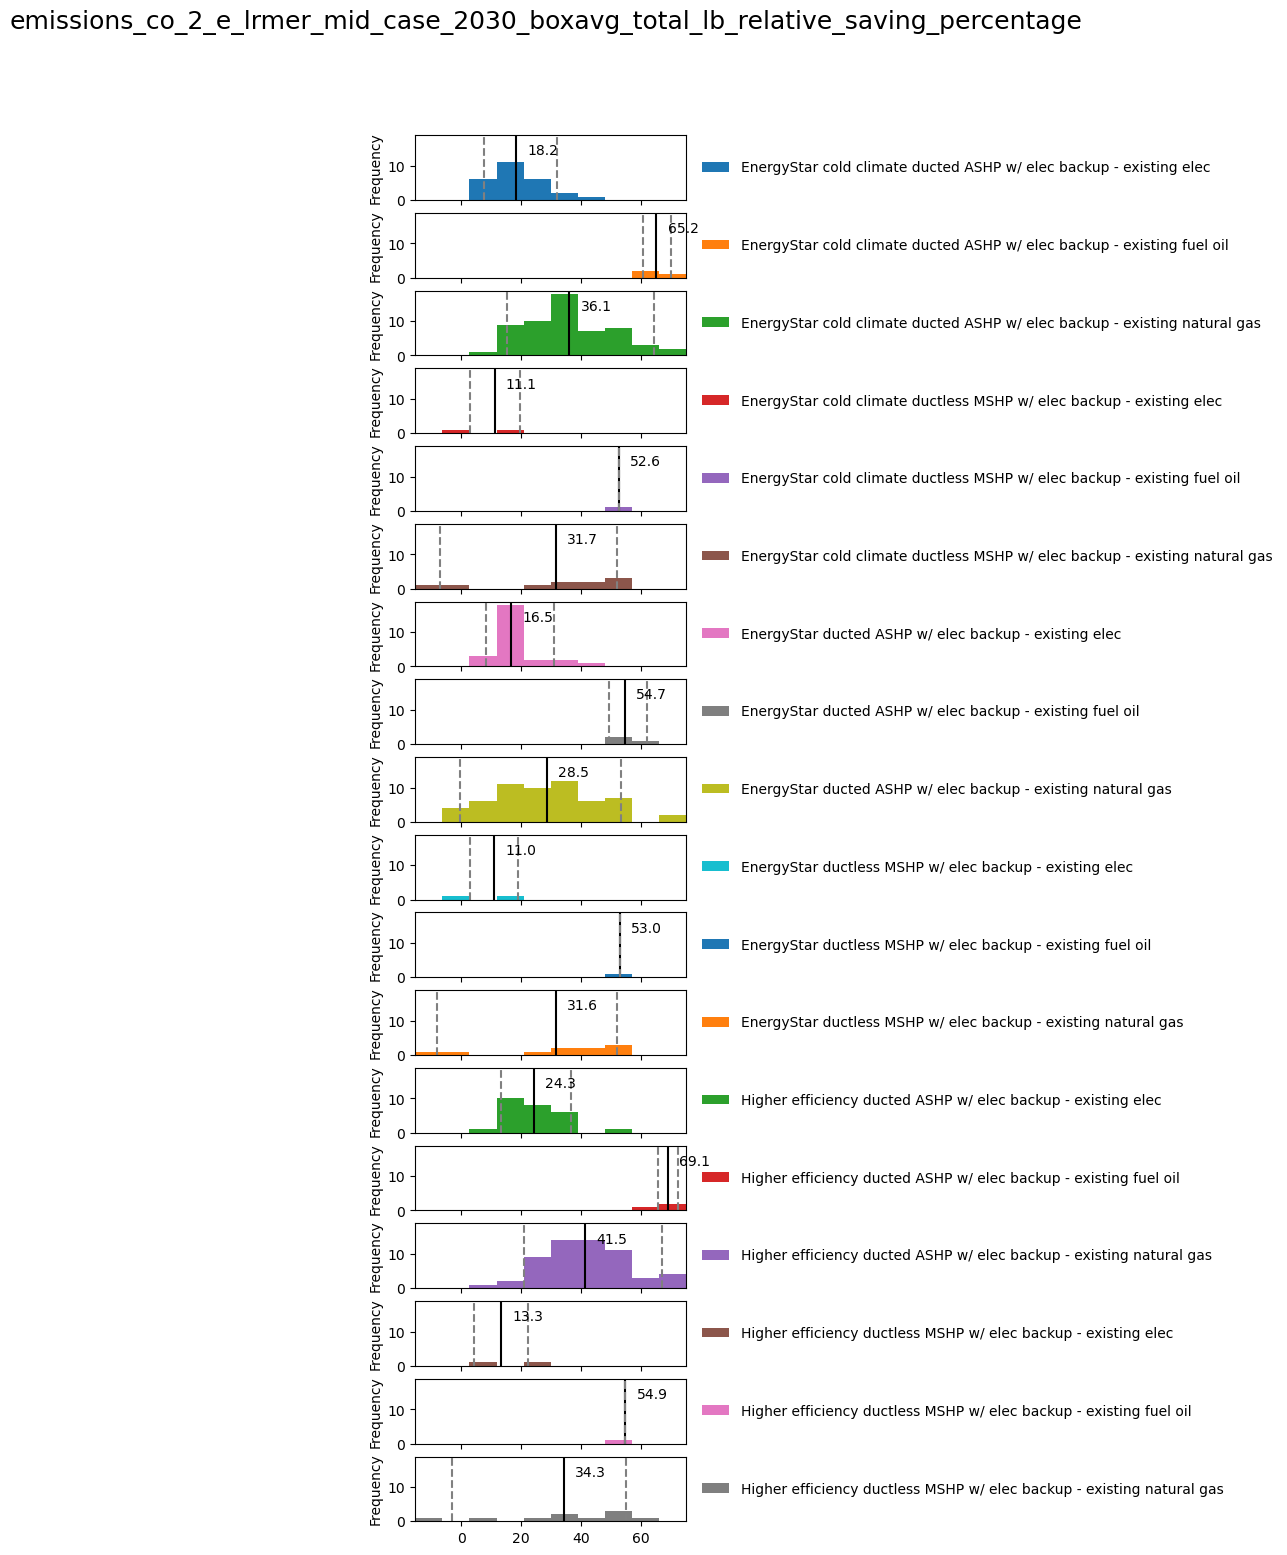

In [99]:
metric = "report_simulation_output.emissions_co_2_e_lrmer_mid_case_2030_boxavg_total_lb"
output_type = "relative_saving_percentage" # negative saving means net increase

hc = ["upgrade"] # "lmi", "tenure"
nbins = 10

dfs = qaqc_helper.load_process.get_upgrade_relative_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

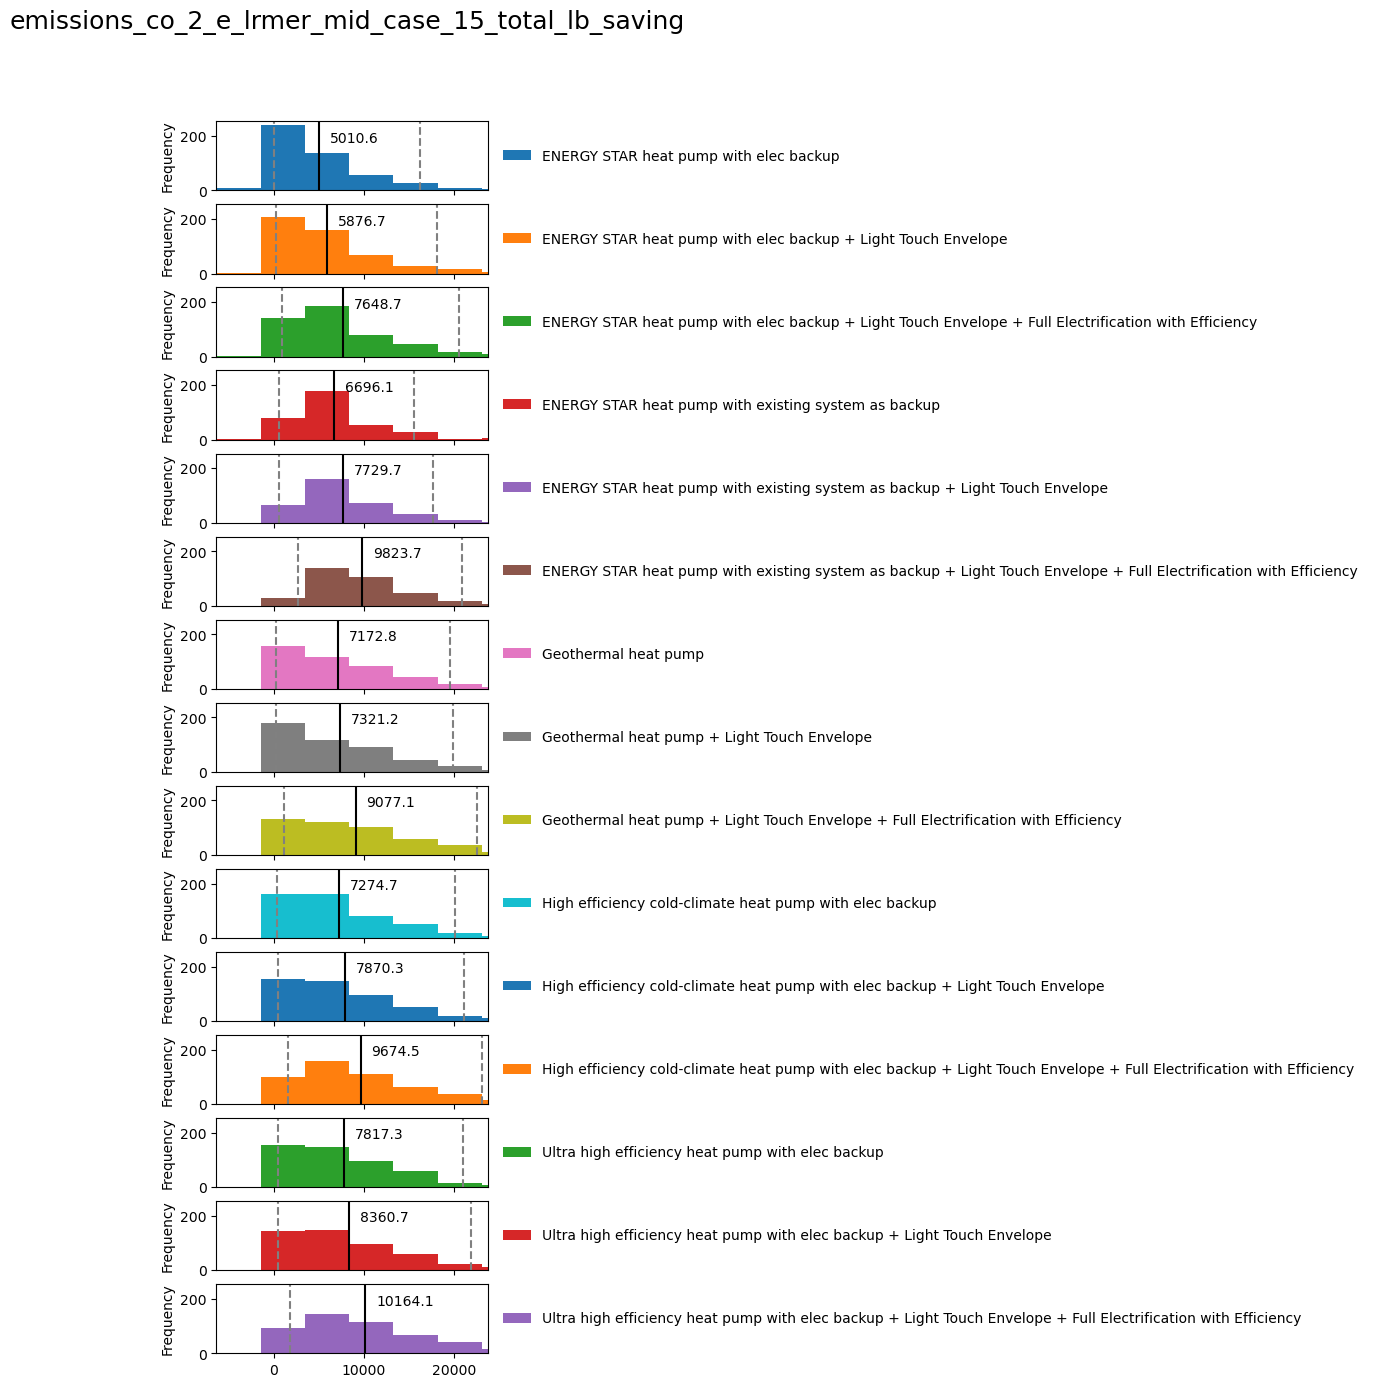

In [24]:
metric = "report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_total_lb"
output_type = "saving" # negative saving means net increase

hc = ["upgrade"] # "lmi", "tenure"
nbins = 10

dfs = qaqc_helper.load_process.get_upgrade_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

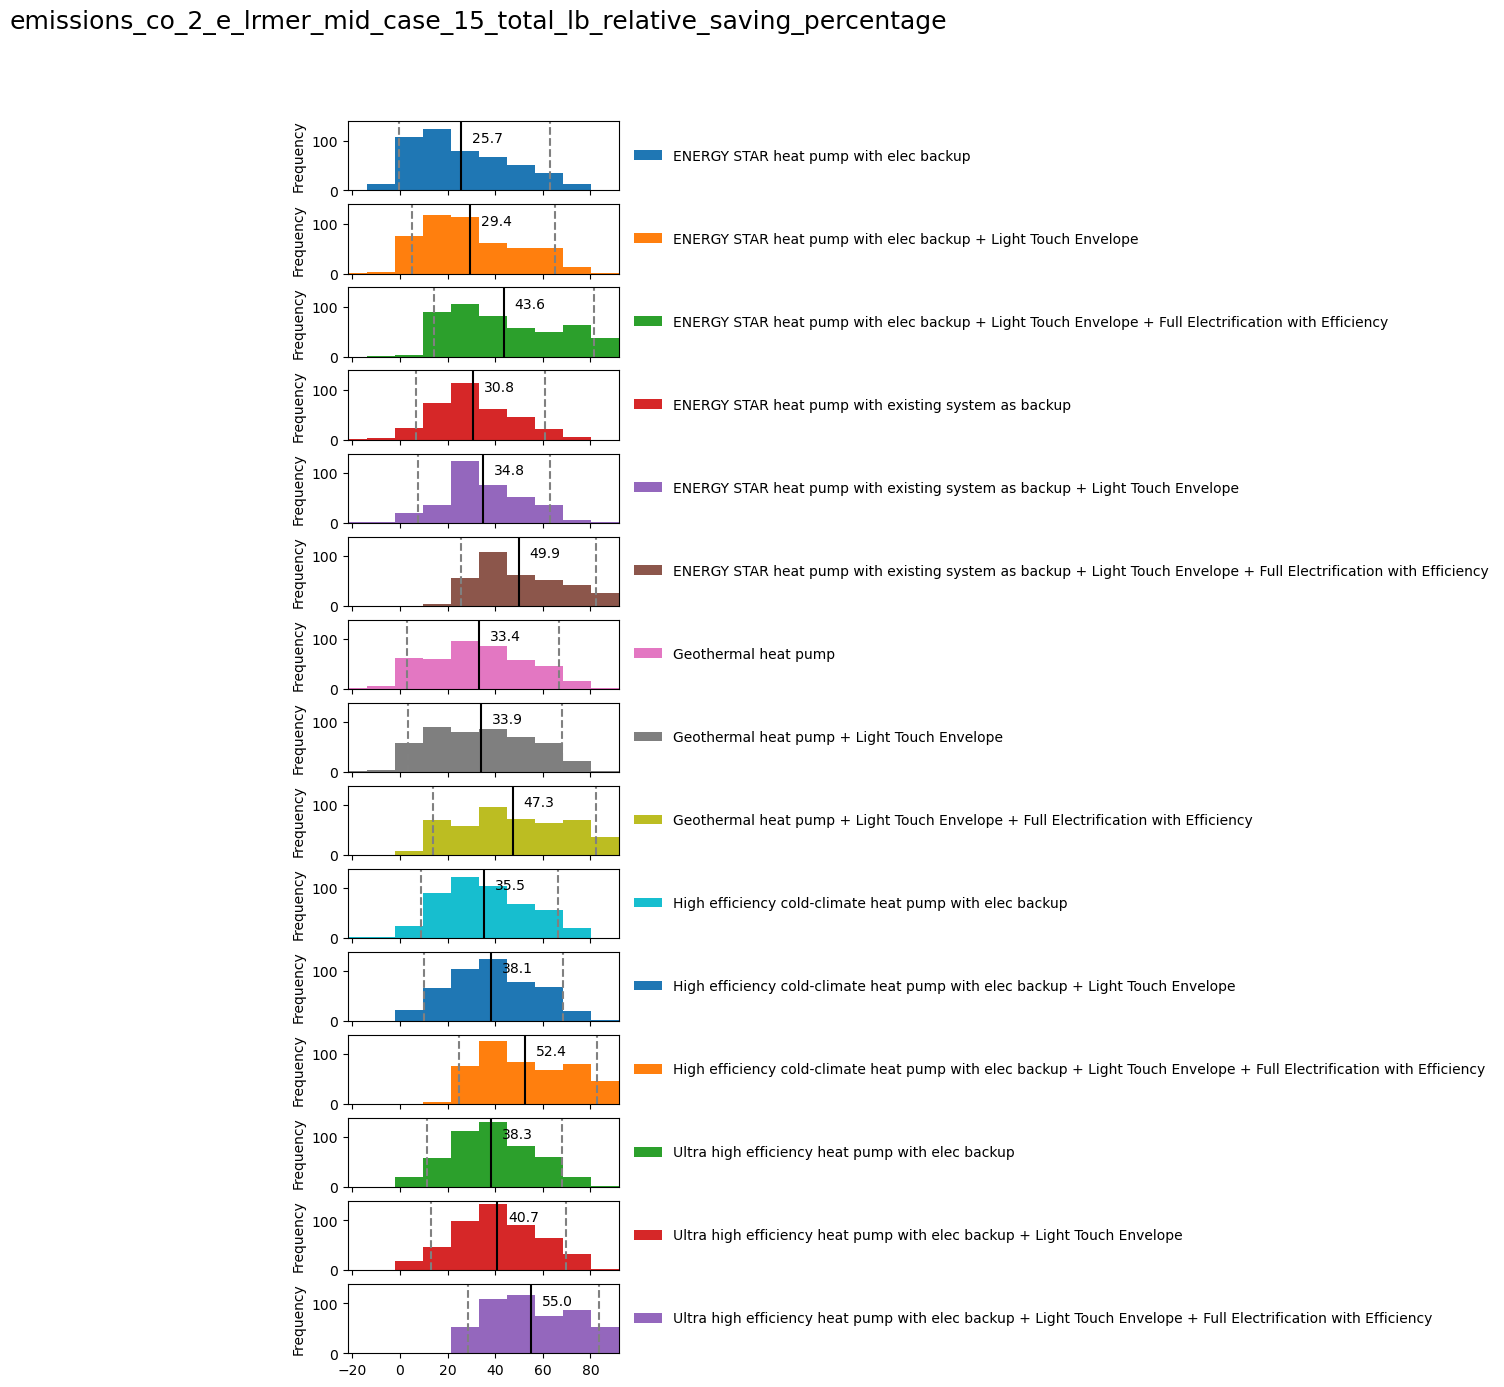

In [25]:
metric = "report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_total_lb"
output_type = "relative_saving_percentage" # negative saving means net increase

hc = ["upgrade"] # "lmi", "tenure"
nbins = 10

dfs = qaqc_helper.load_process.get_upgrade_relative_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

#### 5. End use
Check end use with changes

In [76]:
metric_list = ['report_simulation_output.end_use_coal_clothes_dryer_m_btu',
 'report_simulation_output.end_use_coal_fireplace_m_btu',
 'report_simulation_output.end_use_coal_generator_m_btu',
 'report_simulation_output.end_use_coal_grill_m_btu',
 'report_simulation_output.end_use_coal_heating_heat_pump_backup_m_btu',
 'report_simulation_output.end_use_coal_heating_m_btu',
 'report_simulation_output.end_use_coal_hot_water_m_btu',
 'report_simulation_output.end_use_coal_lighting_m_btu',
 'report_simulation_output.end_use_coal_mech_vent_preheating_m_btu',
 'report_simulation_output.end_use_coal_range_oven_m_btu',
 'report_simulation_output.end_use_electricity_battery_m_btu',
 'report_simulation_output.end_use_electricity_ceiling_fan_m_btu',
 'report_simulation_output.end_use_electricity_clothes_dryer_m_btu',
 'report_simulation_output.end_use_electricity_clothes_washer_m_btu',
 'report_simulation_output.end_use_electricity_cooling_fans_pumps_m_btu',
 'report_simulation_output.end_use_electricity_cooling_m_btu',
 'report_simulation_output.end_use_electricity_dehumidifier_m_btu',
 'report_simulation_output.end_use_electricity_dishwasher_m_btu',
 'report_simulation_output.end_use_electricity_electric_vehicle_charging_m_btu',
 'report_simulation_output.end_use_electricity_freezer_m_btu',
 'report_simulation_output.end_use_electricity_generator_m_btu',
 'report_simulation_output.end_use_electricity_heating_fans_pumps_m_btu',
 'report_simulation_output.end_use_electricity_heating_heat_pump_backup_m_btu',
 'report_simulation_output.end_use_electricity_heating_m_btu',
 'report_simulation_output.end_use_electricity_hot_tub_heater_m_btu',
 'report_simulation_output.end_use_electricity_hot_tub_pump_m_btu',
 'report_simulation_output.end_use_electricity_hot_water_m_btu',
 'report_simulation_output.end_use_electricity_hot_water_recirc_pump_m_btu',
 'report_simulation_output.end_use_electricity_hot_water_solar_thermal_pump_m_btu',
 'report_simulation_output.end_use_electricity_lighting_exterior_m_btu',
 'report_simulation_output.end_use_electricity_lighting_garage_m_btu',
 'report_simulation_output.end_use_electricity_lighting_interior_m_btu',
 'report_simulation_output.end_use_electricity_mech_vent_m_btu',
 'report_simulation_output.end_use_electricity_mech_vent_precooling_m_btu',
 'report_simulation_output.end_use_electricity_mech_vent_preheating_m_btu',
 'report_simulation_output.end_use_electricity_plug_loads_m_btu',
 'report_simulation_output.end_use_electricity_pool_heater_m_btu',
 'report_simulation_output.end_use_electricity_pool_pump_m_btu',
 'report_simulation_output.end_use_electricity_pv_m_btu',
 'report_simulation_output.end_use_electricity_range_oven_m_btu',
 'report_simulation_output.end_use_electricity_refrigerator_m_btu',
 'report_simulation_output.end_use_electricity_television_m_btu',
 'report_simulation_output.end_use_electricity_well_pump_m_btu',
 'report_simulation_output.end_use_electricity_whole_house_fan_m_btu',
 'report_simulation_output.end_use_fuel_oil_clothes_dryer_m_btu',
 'report_simulation_output.end_use_fuel_oil_fireplace_m_btu',
 'report_simulation_output.end_use_fuel_oil_generator_m_btu',
 'report_simulation_output.end_use_fuel_oil_grill_m_btu',
 'report_simulation_output.end_use_fuel_oil_heating_heat_pump_backup_m_btu',
 'report_simulation_output.end_use_fuel_oil_heating_m_btu',
 'report_simulation_output.end_use_fuel_oil_hot_water_m_btu',
 'report_simulation_output.end_use_fuel_oil_lighting_m_btu',
 'report_simulation_output.end_use_fuel_oil_mech_vent_preheating_m_btu',
 'report_simulation_output.end_use_fuel_oil_range_oven_m_btu',
 'report_simulation_output.end_use_natural_gas_clothes_dryer_m_btu',
 'report_simulation_output.end_use_natural_gas_fireplace_m_btu',
 'report_simulation_output.end_use_natural_gas_generator_m_btu',
 'report_simulation_output.end_use_natural_gas_grill_m_btu',
 'report_simulation_output.end_use_natural_gas_heating_heat_pump_backup_m_btu',
 'report_simulation_output.end_use_natural_gas_heating_m_btu',
 'report_simulation_output.end_use_natural_gas_hot_tub_heater_m_btu',
 'report_simulation_output.end_use_natural_gas_hot_water_m_btu',
 'report_simulation_output.end_use_natural_gas_lighting_m_btu',
 'report_simulation_output.end_use_natural_gas_mech_vent_preheating_m_btu',
 'report_simulation_output.end_use_natural_gas_pool_heater_m_btu',
 'report_simulation_output.end_use_natural_gas_range_oven_m_btu',
 'report_simulation_output.end_use_propane_clothes_dryer_m_btu',
 'report_simulation_output.end_use_propane_fireplace_m_btu',
 'report_simulation_output.end_use_propane_generator_m_btu',
 'report_simulation_output.end_use_propane_grill_m_btu',
 'report_simulation_output.end_use_propane_heating_heat_pump_backup_m_btu',
 'report_simulation_output.end_use_propane_heating_m_btu',
 'report_simulation_output.end_use_propane_hot_water_m_btu',
 'report_simulation_output.end_use_propane_lighting_m_btu',
 'report_simulation_output.end_use_propane_mech_vent_preheating_m_btu',
 'report_simulation_output.end_use_propane_range_oven_m_btu',
 'report_simulation_output.end_use_wood_cord_clothes_dryer_m_btu',
 'report_simulation_output.end_use_wood_cord_fireplace_m_btu',
 'report_simulation_output.end_use_wood_cord_generator_m_btu',
 'report_simulation_output.end_use_wood_cord_grill_m_btu',
 'report_simulation_output.end_use_wood_cord_heating_heat_pump_backup_m_btu',
 'report_simulation_output.end_use_wood_cord_heating_m_btu',
 'report_simulation_output.end_use_wood_cord_hot_water_m_btu',
 'report_simulation_output.end_use_wood_cord_lighting_m_btu',
 'report_simulation_output.end_use_wood_cord_mech_vent_preheating_m_btu',
 'report_simulation_output.end_use_wood_cord_range_oven_m_btu',
 'report_simulation_output.end_use_wood_pellets_clothes_dryer_m_btu',
 'report_simulation_output.end_use_wood_pellets_fireplace_m_btu',
 'report_simulation_output.end_use_wood_pellets_generator_m_btu',
 'report_simulation_output.end_use_wood_pellets_grill_m_btu',
 'report_simulation_output.end_use_wood_pellets_heating_heat_pump_backup_m_btu',
 'report_simulation_output.end_use_wood_pellets_heating_m_btu',
 'report_simulation_output.end_use_wood_pellets_hot_water_m_btu',
 'report_simulation_output.end_use_wood_pellets_lighting_m_btu',
 'report_simulation_output.end_use_wood_pellets_mech_vent_preheating_m_btu',
 'report_simulation_output.end_use_wood_pellets_range_oven_m_btu']
output_type = "saving" # negative saving means net increase

dfs = qaqc_helper.load_process.get_upgrade_saving_list_dataframe(dfb, DFU, metric_list, output_type=output_type)
metric_list_new = [x + '_saving' for x in metric_list]
dfs = dfs[metric_list_new]    
temp = dfs.any()
temp = temp.to_frame()
temp.columns =["end_use_with_changes"]
end_use_with_changes = temp.loc[temp["end_use_with_changes"] == True]
end_use_with_changes

,end_use_with_changes
report_simulation_output.end_use_electricity_clothes_dryer_m_btu_saving,True
report_simulation_output.end_use_electricity_cooling_fans_pumps_m_btu_saving,True
report_simulation_output.end_use_electricity_cooling_m_btu_saving,True
report_simulation_output.end_use_electricity_heating_fans_pumps_m_btu_saving,True
report_simulation_output.end_use_electricity_heating_heat_pump_backup_m_btu_saving,True
report_simulation_output.end_use_electricity_heating_m_btu_saving,True
report_simulation_output.end_use_electricity_hot_water_m_btu_saving,True
report_simulation_output.end_use_fuel_oil_heating_m_btu_saving,True
report_simulation_output.end_use_fuel_oil_hot_water_m_btu_saving,True
report_simulation_output.end_use_natural_gas_clothes_dryer_m_btu_saving,True


If there are any unexpected end use with change, then see histogram for end use with changes below

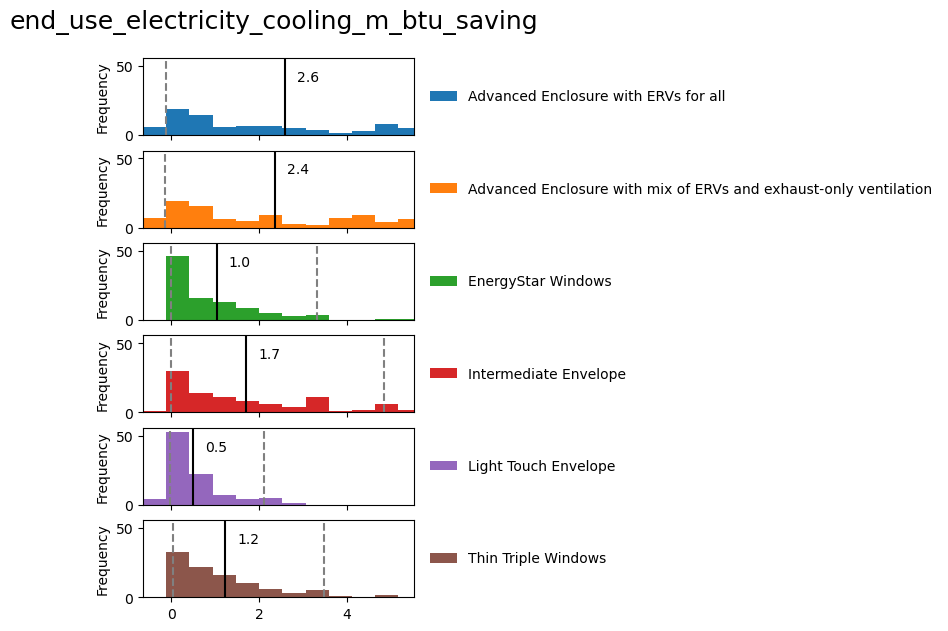

In [48]:
metric = "report_simulation_output.end_use_electricity_cooling_m_btu"
output_type = "saving" # negative saving means net increase

hc = ["upgrade"]
nbins = 20

dfs = qaqc_helper.load_process.get_upgrade_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

#### 6. Fuel and end use savings at individual model level

In [30]:
fuel_list = ['coal', 'electricity','fuel_oil','natural_gas','propane','wood_cord','wood_pellets']
fuel_end_use_with_changes = []
for fuel in fuel_list:
    if dfb[f'report_simulation_output.fuel_use_{fuel}_total_m_btu'].any() == True:
        fuel_end_use_with_changes.append(f'report_simulation_output.fuel_use_{fuel}_total_m_btu')
temp = list(end_use_with_changes.index)
temp = [s.strip('_saving') for s in temp]
fuel_end_use_with_changes.extend(temp)

results = pd.DataFrame()
metric = 'report_simulation_output.fuel_use_electricity_total_m_btu'
output_type = "saving" # negative saving means net increase
temp = qaqc_helper.load_process.get_upgrade_saving_dataframe(dfb, DFU, metric, output_type=output_type)
results['building_id']=temp['building_id']
results['upgrade']=temp['upgrade']

for end_use in fuel_end_use_with_changes:
    metric = end_use
    output_type = "saving" # negative saving means net increase
    temp = qaqc_helper.load_process.get_upgrade_saving_dataframe(dfb, DFU, metric, output_type=output_type)
    results_temp = pd.DataFrame()
    results_temp[f'{end_use}_saving'] = temp[f'{end_use}_saving']
    frames = [results, results_temp]
    results = pd.concat(frames, axis=1)
    
upgrade_list = list(results['upgrade'].unique())
for upgrade in upgrade_list:
    results_upgrade = results.loc[results['upgrade'] == upgrade]
    results_upgrade = results_upgrade.loc[:, (results_upgrade != 0).any(axis=0)]
    results_upgrade.to_csv(f'fuel_end_use_with_changes_{upgrade}.csv')